In [18]:
eventsPath = os.environ["YAHOO_DATA"]
rawEventsRdd = sc.textFile(eventsPath + "events.txt")
rawInstallsRdd = sc.textFile(eventsPath + "installs.txt")
rawMergedRdd = rawEventsRdd.union(rawInstallsRdd)
def parseRawData(line):
    lineSplit = line.split("\t")
    return (lineSplit[0], #userid
              lineSplit[1], #itemid
              int(lineSplit[2]), #ts
              float(lineSplit[3]), #lat
              float(lineSplit[4]), #lon
              lineSplit[5], #city
              int(lineSplit[6]), #day_of_week
              int(lineSplit[7]), #time_of_day
              lineSplit[-1]) #event_type
    

eventsRdd = rawMergedRdd.map(parseRawData).cache()
#userIdConversionDictionary = eventsRdd.map(lambda x: x[0]).distinct().zipWithIndex().collectAsMap()
#itemIdConversionDictionary = eventsRdd.map(lambda x: x[1]).distinct().zipWithIndex().collectAsMap()
#cityConversionDictionary = eventsRdd.map(lambda x: x[5]).distinct().zipWithIndex().collectAsMap()
#USE the same id map always
import json
userIdConversionDictionary = json.load(open(eventsPath  + "/userIdConversionDictionaryMerged.txt"))
itemIdConversionDictionary = json.load(open(eventsPath  + "/itemIdConversionDictionaryMerged.txt"))
cityConversionDictionary = json.load(open(eventsPath  + "/cityConversionDictionaryMerged.txt"))
eventsConvertedRdd = eventsRdd.map(lambda x: (userIdConversionDictionary[x[0]],
    itemIdConversionDictionary[x[1]],
    x[2],
    x[3],
    x[4],
    cityConversionDictionary[x[5]],
    x[6],
    x[7],
    x[8]
    ))

eventsConvertedRdd.take(3)

[(4601, 6339, 1421009506, 47.237476, -122.530884, 8328, 6, 12, u'App_Opened'),
 (4601, 30092, 1421029924, 47.237476, -122.530891, 8328, 6, 18, u'App_Opened'),
 (4601, 98256, 1421015988, 47.237461, -122.530899, 8328, 6, 14, u'App_Opened')]

In [3]:
rawEventsRdd.count(), rawInstallsRdd.count()

(110185157, 785965)

In [4]:
rawEventsRdd.first()

u'001e6d8e-cbe7-4374-8c38-f37962a457e9\tair.com.smashatom.bingo\t1421009506\t47.237476\t-122.530884\tTacoma\t6\t12\tApp_Opened'

### Location context distribution on App_Open events per item(top N run app)

In [3]:
location_context = [(1,0,0), # work
                    (0,1,0), # home
                    (0,0,1)] # other
import os
execfile("../script/utils.py")
eventsPath = os.environ["YAHOO_DATA"]
splitedRdd = sc.textFile(eventsPath + "/splitedDataMerged")
def reduce_helper((x1,x2,x3),(y1,y2,y3)):
    return (x1+y1, x2+y2,x3+y3)
openEventwithLocation = splitedRdd.map(parseContextData2Merged).flatMap(
    lambda x : [ (y.itemId, location_context[y.context.location -1]) for y in x[1][0]+x[1][1]] ).reduceByKey(reduce_helper)
openEventwithLocation.take(1)

[(0, (0, 2, 0))]

In [5]:
openEventwitsubplotshLocationSorted = openEventwithLocation.sortBy(lambda x : (sum(x[1])), ascending=False)
openEventwitsubplotshLocationSorted.take(100)

[(30606, (3432356, 3268456, 3010878)),
 (26351, (2824611, 2475991, 3130106)),
 (111242, (3053164, 2911541, 1874792)),
 (72025, (2705267, 2637588, 1844617)),
 (91506, (1480816, 1349002, 1689121)),
 (59816, (1323460, 1096638, 1379591)),
 (6521, (1101906, 1080690, 736734)),
 (20646, (920031, 818229, 929379)),
 (50418, (725455, 741596, 1032796)),
 (71455, (751289, 666344, 782904)),
 (8200, (857928, 623798, 581381)),
 (89700, (493480, 564652, 777682)),
 (99379, (555196, 535728, 705251)),
 (93947, (613513, 435013, 361465)),
 (104640, (391838, 403834, 583593)),
 (65833, (331402, 401462, 579384)),
 (79843, (482117, 463374, 331620)),
 (16610, (421041, 370693, 471443)),
 (14990, (448991, 372088, 412763)),
 (49632, (413364, 340680, 427906)),
 (17593, (494330, 220481, 457447)),
 (101441, (406378, 335046, 400359)),
 (30092, (342589, 302372, 412994)),
 (91537, (351772, 339953, 329853)),
 (65090, (342076, 283568, 362987)),
 (9538, (346590, 239324, 223158)),
 (106458, (249999, 244401, 220161)),
 (3207

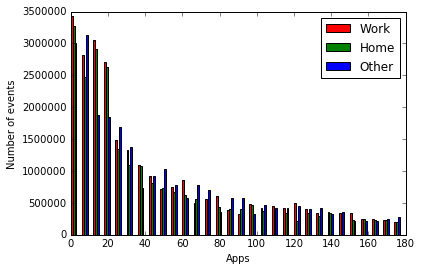

In [21]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
N = 30
datawork = openEventwitsubplotshLocationSorted.map(lambda x : x[1][0]).take(N)
datahome = openEventwitsubplotshLocationSorted.map(lambda x : x[1][1]).take(N)
dataother = openEventwitsubplotshLocationSorted.map(lambda x : x[1][2]).take(N)
b1 = plt.bar(range(0,6*N,6),datawork,1, color='r')
b2 = plt.bar(range(1,6*N+1,6),datahome,1, color='g')
b3 = plt.bar(range(2,6*N+2,6),dataother,1, color='b')
plt.legend((b1[0], b2[0], b3[0]),('Work','Home','Other'))
plt.ylabel('Number of events')
plt.xlabel('Apps')
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "contextlocationvsitem" + str(int(time.time())) + ".png")
plt.show()



In [26]:
import os
execfile("../script/utils.py")
eventsPath = os.environ["YAHOO_DATA"]
splitedRdd = sc.textFile(eventsPath + "/splitedDataMerged")
time_context = [(1,0,0,0), # morning
                (0,1,0,0), # afternoon
                (0,0,1,0), # evening
                (0,0,0,1)] # night
def reduce_helper2((x1,x2,x3,x4),(y1,y2,y3,y4)):
    return (x1+y1, x2+y2,x3+y3,x4+y4)
openEventwithTime = splitedRdd.map(parseContextData2Merged).flatMap(
    lambda x : [ (y.itemId, time_context[y.context.time_of_day -1]) for y in x[1][0]+x[1][1]] ).reduceByKey(reduce_helper2)
# openEventOverAll = openEventwithTime.map(lambda x: x[1]).reduce(reduce_helper2)
# openEventOverAll
#openEventwithTimeSorted = openEventwithTime.sortBy(lambda x : (sum(x[1])), ascending=False)
#openEventwithTimeSorted.take(100)
openEventwithTime.take(5)

[(0, (0, 2, 0, 0)),
 (6657, (0, 1, 5, 0)),
 (13314, (4, 8, 4, 11)),
 (19971, (42, 83, 70, 46)),
 (26628, (4, 6, 2, 2))]

In [47]:
import math
def timeMatters(lines):
    if (math.fabs(1.0*lines[1][0]/lines[1][4]-0.24867111302) > 0.4 or \
        math.fabs(1.0*lines[1][1]/lines[1][4]-0.29859594757) > 0.4 or \
        math.fabs(1.0*lines[1][2]/lines[1][4]-0.25037886825) > 0.4 or \
        math.fabs(1.0*lines[1][3]/lines[1][4]-0.20235407115) > 0.4) and \
        lines[1][4] > 30:
            flag = 1
    else:
        flag = 0
    return lines[0],(lines[1][0],lines[1][1],lines[1][2],lines[1][3],lines[1][4]),flag
openEventwithTimeMatter = openEventwithTime.map(lambda x: (x[0],(x[1][0],x[1][1],x[1][2],x[1][3],sum(x[1])))).map(timeMatters)
openEventwithTimeFiltered = openEventwithTimeMatter.filter(lambda x: x[2]==1).map(lambda x:(x[0],x[2]))
openEventwithTimeFilteredA = openEventwithTimeFiltered.collectAsMap()

In [48]:
openEventwithTimeFiltered.count()

335

In [43]:
import json
with open(eventsPath + 'openEventwithTimeFiltered.txt', 'w') as outfile:
    json.dump(openEventwithTimeFilteredA, outfile)

In [ ]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
N = 100
datamorning = openEventwithTimeSorted.map(lambda x : x[1][0]).take(N)
dataafternoon = openEventwithTimeSorted.map(lambda x : x[1][0]).take(N)
dataevening = openEventwithTimeSorted.map(lambda x : x[1][1]).take(N)
datanight = openEventwithTimeSorted.map(lambda x : x[1][2]).take(N)
b1 = plt.bar(range(0,6*N,6),datamorning,1, color='r')
b2 = plt.bar(range(1,6*N+1,6),dataafternoon,1, color='g')
b3 = plt.bar(range(2,6*N+2,6),dataevening,1, color='b')
b4 = plt.bar(range(3,6*N+3,6),datanight,1, color='y')
#plt.legend((b1[0], b2[0], b3[0], b4[0]),('Morning','Afternoon', 'Evening','Night'))
plt.ylabel('Number of events')
plt.xlabel('Apps')
plt.figure(figsize=(70, 70))
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "contexttime-of-day-vsitem" + str(int(time.time())) + ".png",dpi=200)
plt.show()


### Number of open events vs application

In [19]:
onlyOpenEvents = rawEventsRdd.map(
    parseRawData).map(lambda x : (itemIdConversionDictionary[x[1]],1))
appvsruntime = onlyOpenEvents.reduceByKey(lambda a,b : a + b).sortBy(lambda x: x[1], ascending=False)
appvsruntime.take(3)


[(30606, 9712865), (26351, 8431821), (111242, 7840438)]

In [20]:
import json
userappmap = json.load(open(eventsPath + "/userAppMap.txt"))
def findKey(d, v):
    for k, val in d.iteritems():
        if val == v:
            return k
listofapps = [ (findKey(itemIdConversionDictionary, v[0]), v[1], v[0]) for v in appvsruntime.take(100)]
stats_dir = eventsPath + "/stats/"
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)
numberOfEvents = float(eventsRdd.count()) / 100
outfile = open(stats_dir + "topapps_run_byusers.csv",'w')
outfile.write("Appid,App,#usersruntheapp, percentage\n")
for el in listofapps:
    outfile.write(str(el[2]) + ',' + str(el[0]) + "," + str(el[1]) + "," + str(el[1]/numberOfEvents) + '\n')
outfile.close()

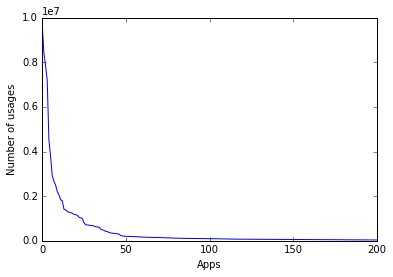

In [44]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
data= appvsruntime.map(lambda x : x[1]).collect()
plt.plot(data)
plt.ylabel('Number of usages')
plt.xlabel('Apps')
plt.axis([0,200,0 , 1e7])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "numberofusagevsapp" + str(int(time.time())) + ".png")
plt.show()

### Percentage of usage over all events per app

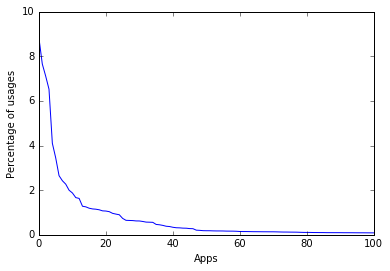

In [13]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
try:
    data
except NameError:
    data= appvsruntime.map(lambda x : x[1]).collect()
itemCount = float(110185157) / 100
plt.plot([el/itemCount for el in data])
plt.ylabel('Percentage of usages')
plt.xlabel('Apps')
plt.axis([0,100,0 , 10])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "percentageofusagevsapp" + str(int(time.time())) + ".png")
plt.show()


## Graphs of users installed per application

In [16]:
userappmaprdd = sc.parallelize([ (int(k), userappmap[k]) for k in userappmap.keys()])
userappmaprdd = userappmaprdd.flatMap(lambda x : [ (k, 1) for k in x[1] ] ) #(itemid, 1) format
userappmaprdd = userappmaprdd.reduceByKey(
    lambda a,b : a + b).sortBy(lambda x : x[1], ascending=False)

In [21]:
def findKey(d, v):
    for k, val in d.iteritems():
        if val == v:
            return k
listofapps = [ (findKey(itemIdConversionDictionary, v[0]), v[1], v[0]) for v in userappmaprdd.take(100)]
stats_dir = eventsPath + "/stats/"
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)
numberOfUsers = float(len(userappmap))
outfile = open(stats_dir + "topapps_owned_byusers.csv",'w')
outfile.write("Appid,App,#usersowntheapp, percentage\n")
for el in listofapps:
    outfile.write(str(el[2]) + ',' + str(el[0]) + "," + str(el[1]) + "," + str(el[1]/numberOfUsers) + '\n')
outfile.close()


### Number of users installed per application

In [ ]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
dataiteminstall= userappmaprdd.map(lambda x : x[1]).collect()
plt.plot(dataiteminstall)
plt.ylabel('Number of installs')
plt.xlabel('Apps')
plt.axis([0,10000, 0, 2000])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "numberofinstallperapp" + str(int(time.time())) + ".png")
plt.show()

### Percentage of users installed per application

In [ ]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
try:
    dataiteminstall
except NameError:
    dataiteminstall= userappmaprdd.map(lambda x : x[1]).collect()
numberOfUsers = float(len(userappmap))
plt.plot([el/numberOfUsers for el in dataiteminstall])
plt.ylabel('Percentage of users own the app')
plt.xlabel('Apps')
plt.axis([0,1000, 0.0, 0.5])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "percentageofusersownedvsapp" + str(int(time.time())) + ".png")
plt.show()

# Histogram of users having certain number of apps

In [5]:
import os
import numpy as np
execfile("../script/utils.py")
eventsPath = os.environ["YAHOO_DATA"]
splitedRdd = sc.textFile(eventsPath + "/splitedDataMerged")
splitedRdd = splitedRdd.map(parseContextData2Merged).map(lambda x :  (len(x[1][1]) + len(x[1][0])))
splitedRdd.mean() # average number of events per user 559.8407598642079

559.8407598642079

In [ ]:
intervalsLarge = np.arange(0,9001,1000).tolist()
histDataOpenlarge = splitedRdd.histogram(intervalsLarge)
intervalsSmall = np.arange(0,8601,100).tolist()
histDataOpenSmall = splitedRdd.histogram(intervalsSmall)
#splitedRdd.max() 8597

In [17]:
histDataOpenlarge

([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
 [170547, 26967, 3287, 498, 113, 21, 11, 3, 3])

### Histogram of number opens per user 1000 interval adopted

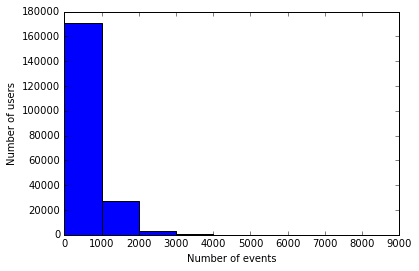

In [24]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
plt.bar(histDataOpenlarge[0][:-1], histDataOpenlarge[1], width=1000 )
plt.ylabel('Number of users')
plt.xlabel('Number of events')
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "histof_#opens_peruser_1000int" + str(int(time.time())) + ".png")
plt.show()

### Histogram of number opens per user 100 interval adopted

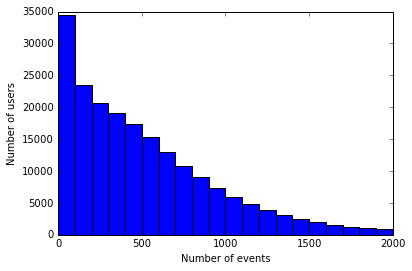

In [25]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
plt.bar(histDataOpenSmall[0][:-1], histDataOpenSmall[1], width=100 )
plt.ylabel('Number of users')
plt.xlabel('Number of events')
plt.axis([0,2000,0,35000])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "histof_#opens_peruser_100int" + str(int(time.time())) + ".png")
plt.show()

### Histogram of the number of applications owned by each user

In [6]:
import json
userappmap = json.load(open(eventsPath + "/userAppMap.txt"))
userappcountrdd = sc.parallelize([len(v) for k,v in userappmap.iteritems()])
intervalAppCount = [0,10,20,30,40,50,60,70,100,260]
histDataAppcount = userappcountrdd.histogram(intervalAppCount)
userappcountrdd.mean(), userappcountrdd.max(), userappcountrdd.count()

(33.15867957309499, 257, 201450)

In [30]:
histDataAppcount

([0, 10, 20, 30, 40, 50, 60, 70, 100, 150, 200, 260],
 [10369, 28266, 47468, 52043, 35778, 17107, 6501, 3589, 303, 23, 3])

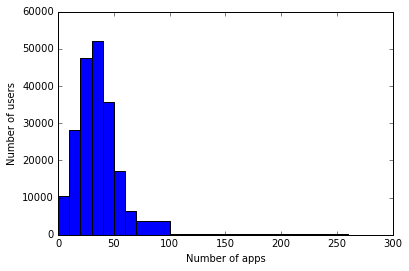

In [7]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
plt.bar(histDataAppcount[0][:-1], histDataAppcount[1],
        width=[x - intervalAppCount[i - 1] for i, x in enumerate(intervalAppCount)][1:])
plt.ylabel('Number of users')
plt.xlabel('Number of apps')

figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "histof_#opens_peruser_100int" + str(int(time.time())) + ".png")
plt.show()

# Statistics on Events that has an item with a category

In [ ]:
import os
execfile("../script/utils.py")
eventsPath = os.environ["YAHOO_DATA"]
splitedRdd = sc.textFile(eventsPath + "/splitedDataMergedCatFiltered")
splitedRdd = splitedRdd.map(parseContextData2MergedFiltered)
splitedRdd.first()

In [79]:
#number of events:
def reduce_helper((a,b,c),(x,y,z)):
    return a+x,b+y,c+z
numberPerUser = splitedRdd.map(lambda x : (len(x[1][0])+len(x[1][1]), len(x[1][2]),len(x[1][3])))
numberPerUser.reduce(reduce_helper)

(57486572, 400959, 258051)

## Usage graphs

In [82]:
appvsruntime = splitedRdd.flatMap(lambda x: (x[1][0] + x[1][1])).map(lambda x : (x.itemId, 1)).reduceByKey(lambda x,y : x + y)
appvsruntime = appvsruntime.sortBy(lambda x: x[1], ascending=False)
appvsruntime.take(3)


[(13314, 27), (19971, 241), (46599, 28)]

In [84]:
appvsruntime = appvsruntime.sortBy(lambda x: x[1], ascending=False)
appvsruntime.take(3)

[(26351, 8430708), (59816, 3799689), (50418, 2499847)]

In [85]:
import json
itemIdConversionDictionary = json.load(open(eventsPath  + "/itemIdConversionDictionaryMerged.txt"))
def findKey(d, v):
    for k, val in d.iteritems():
        if val == v:
            return k
listofapps = [ (findKey(itemIdConversionDictionary, v[0]), v[1], v[0]) for v in appvsruntime.take(100)]
stats_dir = eventsPath + "/stats/"
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)
numberOfEvents = float(57486572) / 100
outfile = open(stats_dir + "topapps_run_byusers_filtered.csv",'w')
outfile.write("Appid,App,#usersruntheapp, percentage\n")
for el in listofapps:
    outfile.write(str(el[2]) + ',' + str(el[0]) + "," + str(el[1]) + "," + str(el[1]/numberOfEvents) + '\n')
outfile.close()

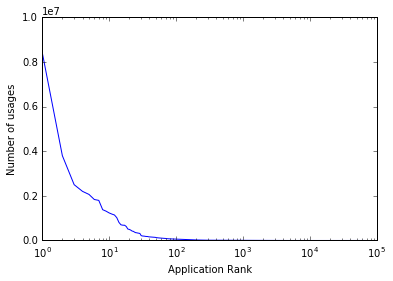

In [104]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
data= appvsruntime.map(lambda x : x[1]).collect()
plt.semilogx([data[0]] + data)
plt.ylabel('Number of usages')
plt.xlabel('Application Rank')
plt.axis([0,1e5,0 , 1e7])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "numofusagevsapp_logscale" + str(int(time.time())) + "filtered.png",dpi=200)
plt.show()

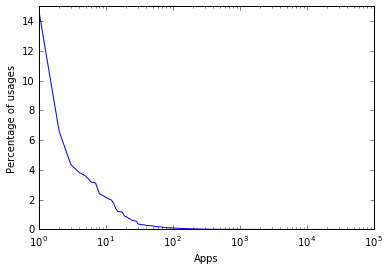

In [103]:
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline
try:
    data
except NameError:
    data= appvsruntime.map(lambda x : x[1]).collect()
itemCount = float(57486572) / 100
tes = [el/itemCount for el in data]
plt.semilogx([tes[0]] + tes)
plt.ylabel('Percentage of usages')
plt.xlabel('Apps')
plt.axis([0,1e5,0 , 15])
figure_dir = eventsPath + "/figures/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
plt.savefig(figure_dir + "percofusagevsapp_logscale" + str(int(time.time())) + "_filtered.png")
plt.show()